# Import all required Libraries  in the first python cell not separate cells (1 mark). 


In [19]:
# ========================================
# ENHANCED LOAN PREDICTION - MULTIPLE MODELS
# Models: Random Forest, XGBoost, LightGBM, Neural Network
# ========================================

import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)
import warnings
warnings.filterwarnings("ignore")

# ML Models
import xgboost as xgb
import lightgbm as lgb

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


# Load and read dataset and Display first 5 records in only second python cell (1 marks)

In [20]:
# ========================================
# 1. LOAD DATASET
# ========================================

dataset_path = Path('train.csv')

try:
    df = pd.read_csv(dataset_path)
    print("✅ Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
except Exception as e:
    print(f"❌ Error loading dataset: {e}")

✅ Dataset loaded successfully!
Shape: (593994, 13)

First 5 rows:


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


# Display dataset shape (total rows and colums), Uniques values for target feature, Sum of missing values if all colums. (1.5 marks) in only third python cell

In [21]:
# ========================================
# 2. DATA EXPLORATION
# ========================================

print(f"\n{'='*60}")
print("DATA EXPLORATION")
print(f"{'='*60}")
print(f"Dataset shape: {df.shape}")
print(f"Target unique values: {df.loan_paid_back.unique()}")
print(f"Null values:\n{df.isnull().sum()}")


DATA EXPLORATION
Dataset shape: (593994, 13)
Target unique values: [1. 0.]
Null values:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64


# Target Distribution in forth python cell. (1 mark)

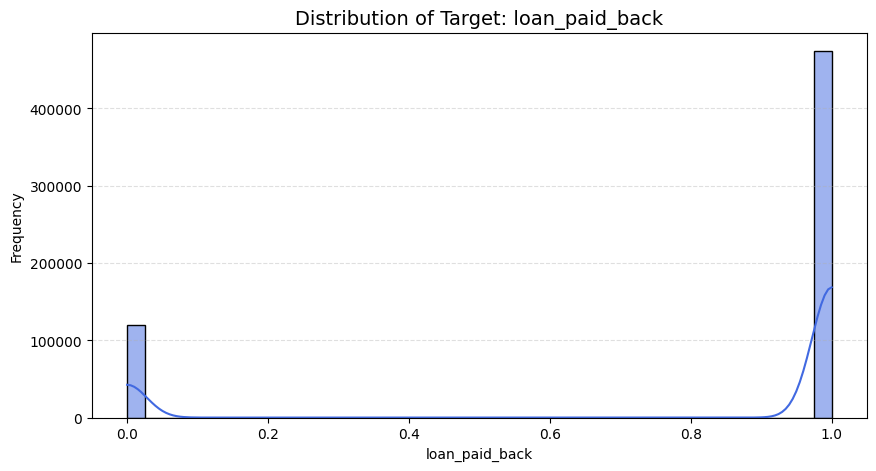


Target distribution:
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


In [22]:
# Target distribution
target = "loan_paid_back"
plt.figure(figsize=(10, 5))
sns.histplot(df[target], kde=True, bins=40, color="royalblue")
plt.title(f"Distribution of Target: {target}", fontsize=14)
plt.xlabel(target)
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

print(f"\nTarget distribution:")
print(df[target].value_counts(normalize=True))

### By Using IQR do the following:
# Detect and display total outliers
# display outliers appear in each numeric columns
# Display rows with at least one outlier
# Display all outliers in dataframe.

### Total Marks: (2 marks). In Firth Python Cell

In [23]:
# ========================================
# 3. HANDLE MISSING VALUES & OUTLIERS
# ========================================

# Select numeric columns
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

# IQR outlier detection - EXCLUDE TARGET COLUMN
num_cols_for_outlier = [col for col in num_cols if col != 'loan_paid_back']

Q1 = df[num_cols_for_outlier].quantile(0.25)
Q3 = df[num_cols_for_outlier].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (df[num_cols_for_outlier] < lower_bound) | (df[num_cols_for_outlier] > upper_bound)
total_outliers = outlier_mask.sum().sum()
print(f"\n📊 Detected {total_outliers} outlier values (IQR Method)")

# Remove outliers
mask = (df[num_cols_for_outlier] >= lower_bound) & (df[num_cols_for_outlier] <= upper_bound)
df = df[mask.all(axis=1)]

# VERIFY both classes still exist
print(f"✅ Data shape after outlier removal: {df.shape}")
print(f"✅ Target distribution after outlier removal:")
print(df['loan_paid_back'].value_counts())

# Safety check
if df['loan_paid_back'].nunique() < 2:
    print("⚠️ WARNING: Only one class remains! Skipping outlier removal.")
    # Reload data without outlier removal
    df = pd.read_csv(dataset_path)
    df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))


📊 Detected 47412 outlier values (IQR Method)
✅ Data shape after outlier removal: (548557, 13)
✅ Target distribution after outlier removal:
loan_paid_back
1.0    445237
0.0    103320
Name: count, dtype: int64


FEATURE ENGINEERING

In [24]:
# ========================================
# 4. FEATURE ENGINEERING
# ========================================

# Drop ID column if exists
if 'id' in df.columns:
    df = df.drop(columns=['id'], axis=1)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'loan_paid_back' in categorical_cols:
    categorical_cols.remove('loan_paid_back')

print(f"\n📝 Categorical columns to encode: {categorical_cols}")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("✅ Label encoding completed")


📝 Categorical columns to encode: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
✅ Label encoding completed


train test split

In [25]:
# ========================================
# 5. TRAIN-TEST SPLIT
# ========================================

X = df.drop('loan_paid_back', axis=1)
y = df['loan_paid_back']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"\n📊 Train samples: {X_train.shape}")
print(f"📊 Test samples: {X_test.shape}")


📊 Train samples: (438845, 11)
📊 Test samples: (109712, 11)


# Feature Scaling to prevent Data Leakage problem.

## in 13th python cell

# (1 marks)

In [26]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed")

✅ Feature scaling completed


In [27]:
# ========================================
# 6. MODEL TRAINING & EVALUATION
# ========================================

def evaluate_model(name, model, X_train, X_test, y_train, y_test, is_nn=False):
    """Evaluate model performance"""
    print(f"\n{'='*60}")
    print(f"🔍 EVALUATING: {name}")
    print(f"{'='*60}")
    
    # Training
    if is_nn:
        # Neural network already trained
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba.flatten()
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"✅ Accuracy:  {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")
    print(f"✅ F1-Score:  {f1:.4f}")
    print(f"✅ ROC-AUC:   {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Rejected', 'Approved'],
                yticklabels=['Rejected', 'Approved'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return {
        'model': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Store results
results = []


🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲
TRAINING RANDOM FOREST
🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲🌲

🔍 EVALUATING: Random Forest
✅ Accuracy:  0.9094
✅ Precision: 0.9097
✅ Recall:    0.9863
✅ F1-Score:  0.9465
✅ ROC-AUC:   0.9121


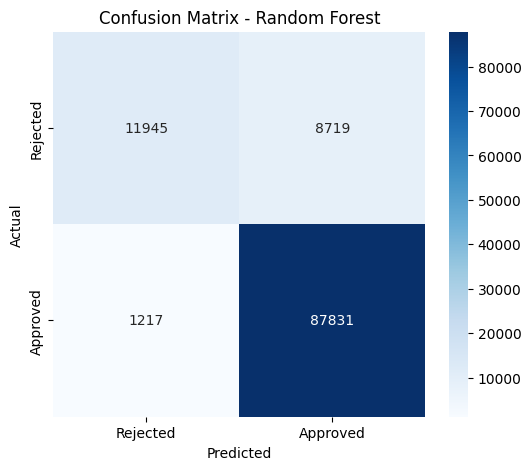

In [28]:
print("\n" + "🌲" * 30)
print("TRAINING RANDOM FOREST")
print("🌲" * 30)

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

results = []

rf_results = evaluate_model(
    "Random Forest",
    rf_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test
)

results.append(rf_results)



🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
TRAINING XGBOOST
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🔍 EVALUATING: XGBoost
✅ Accuracy:  0.9097
✅ Precision: 0.9147
✅ Recall:    0.9802
✅ F1-Score:  0.9463
✅ ROC-AUC:   0.9168


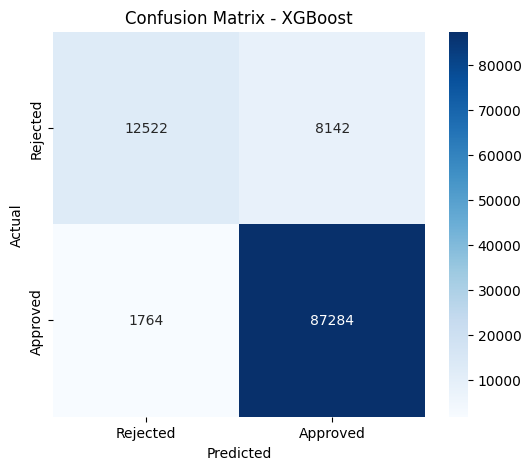

In [29]:
# ========================================
# MODEL 2: XGBOOST
# ========================================

print("\n" + "🚀" * 30)
print("TRAINING XGBOOST")
print("🚀" * 30)

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_results = evaluate_model(
    "XGBoost", 
    xgb_model, 
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test
)
results.append(xgb_results)


⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡
TRAINING LIGHTGBM
⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡

🔍 EVALUATING: LightGBM
✅ Accuracy:  0.9117
✅ Precision: 0.9148
✅ Recall:    0.9827
✅ F1-Score:  0.9475
✅ ROC-AUC:   0.9212


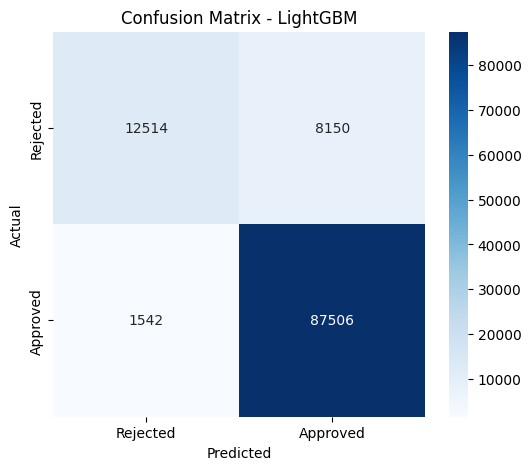

In [30]:
# ========================================
# MODEL 3: LIGHTGBM
# ========================================

print("\n" + "⚡" * 30)
print("TRAINING LIGHTGBM")
print("⚡" * 30)

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

lgb_results = evaluate_model(
    "LightGBM", 
    lgb_model, 
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test
)
results.append(lgb_results)


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
MODEL COMPARISON
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

📊 Model Performance Comparison:


,model,accuracy,precision,recall,f1_score,roc_auc
2,LightGBM,0.911660,0.914799,0.982683,0.947527,0.921249
1,XGBoost,0.909709,0.914677,0.980190,0.946301,0.916781
0,Random Forest,0.909436,0.909694,0.986333,0.946465,0.912084


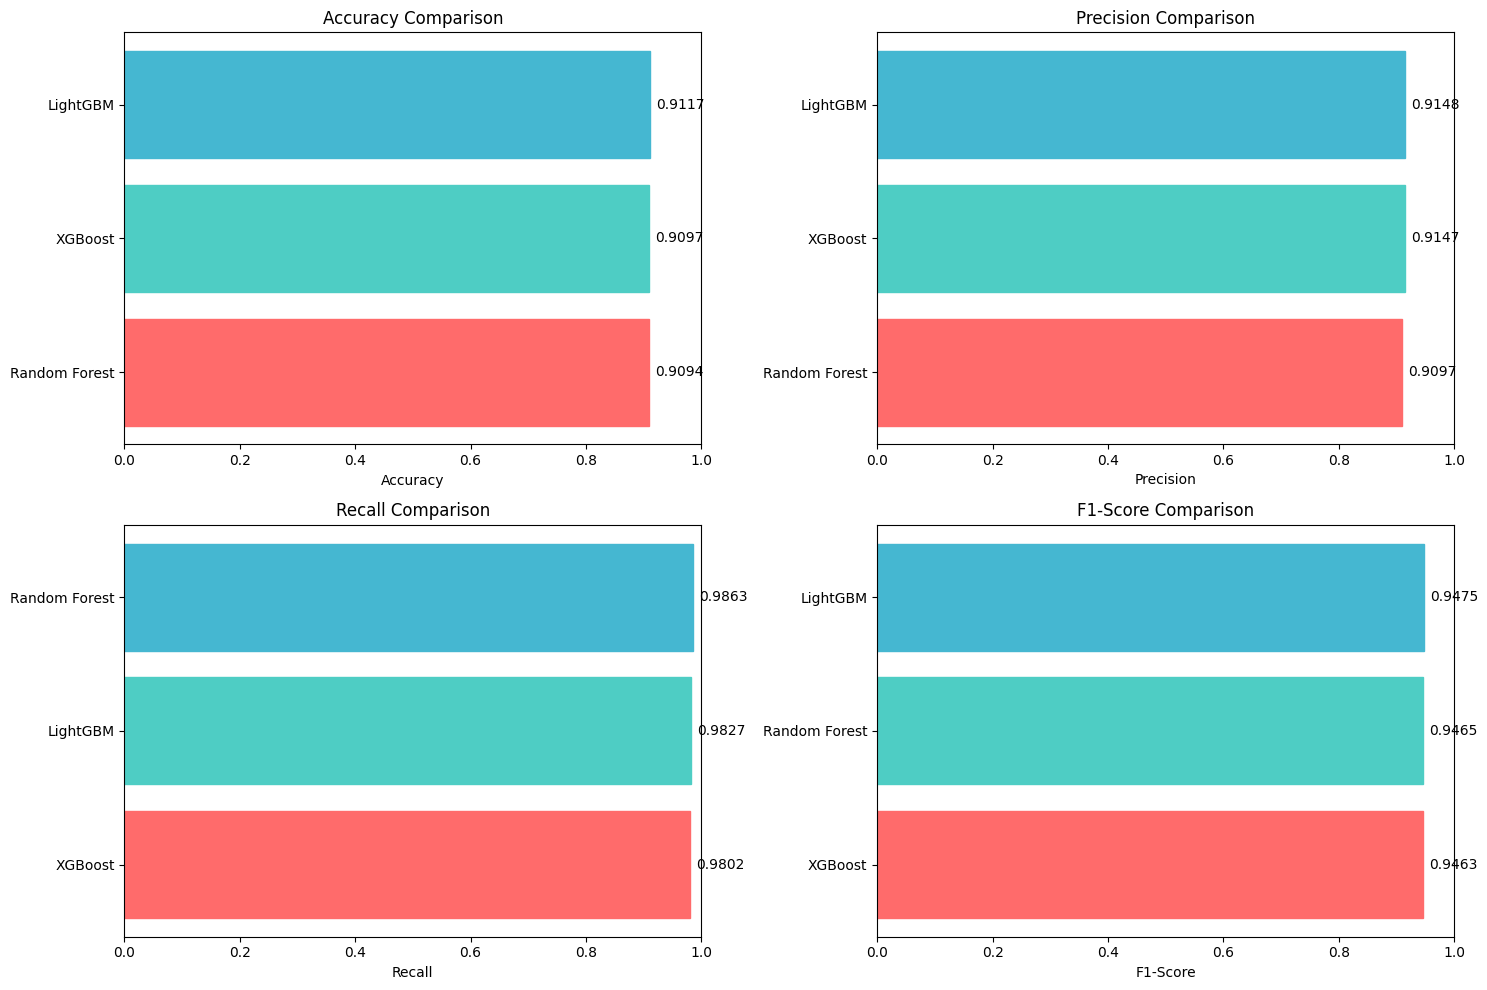

In [31]:
# ========================================
# 7. MODEL COMPARISON
# ========================================

print("\n" + "🏆" * 30)
print("MODEL COMPARISON")
print("🏆" * 30)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('accuracy', ascending=False)

print("\n📊 Model Performance Comparison:")
display(results_df)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    results_df_sorted = results_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(results_df_sorted['model'], results_df_sorted[metric])
    
    # Color bars
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax.set_xlabel(title)
    ax.set_xlim([0, 1])
    ax.set_title(f'{title} Comparison')
    
    # Add value labels
    for i, v in enumerate(results_df_sorted[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


In [ ]:
# ========================================
# 8. SELECT BEST MODEL
# ========================================

best_model_name = results_df.iloc[0]['model']
best_accuracy = results_df.iloc[0]['accuracy']

print(f"\n{'='*60}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Accuracy: {best_accuracy:.4f}")
print(f"{'='*60}")

# Select the best model object
model_mapping = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
}

best_model = model_mapping[best_model_name]


🏆 BEST MODEL: LightGBM
🎯 Accuracy: 0.9117


In [33]:
# ========================================
# 9. SAVE BEST MODEL (NO NEURAL NETWORK)
# ========================================

print("\n💾 Saving best model and preprocessing objects...")

# Save model (classical ML models only)
joblib.dump(best_model, 'model.pkl')
print(f"✅ {best_model_name} saved as model.pkl")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler saved as scaler.pkl")

# Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("✅ Label encoders saved as label_encoders.pkl")

# Save feature names
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("✅ Feature names saved")

print("\n" + "="*60)
print("✅ ALL FILES SAVED SUCCESSFULLY!")
print("="*60)



💾 Saving best model and preprocessing objects...
✅ LightGBM saved as model.pkl
✅ Scaler saved as scaler.pkl
✅ Label encoders saved as label_encoders.pkl
✅ Feature names saved

✅ ALL FILES SAVED SUCCESSFULLY!



📊 Feature Importance - LightGBM


,feature,importance
1,debt_to_income_ratio,3605
2,credit_score,2337
3,loan_amount,2175
4,interest_rate,2107
0,annual_income,2027
10,grade_subgrade,850
9,loan_purpose,518
8,employment_status,515
7,education_level,404
6,marital_status,273


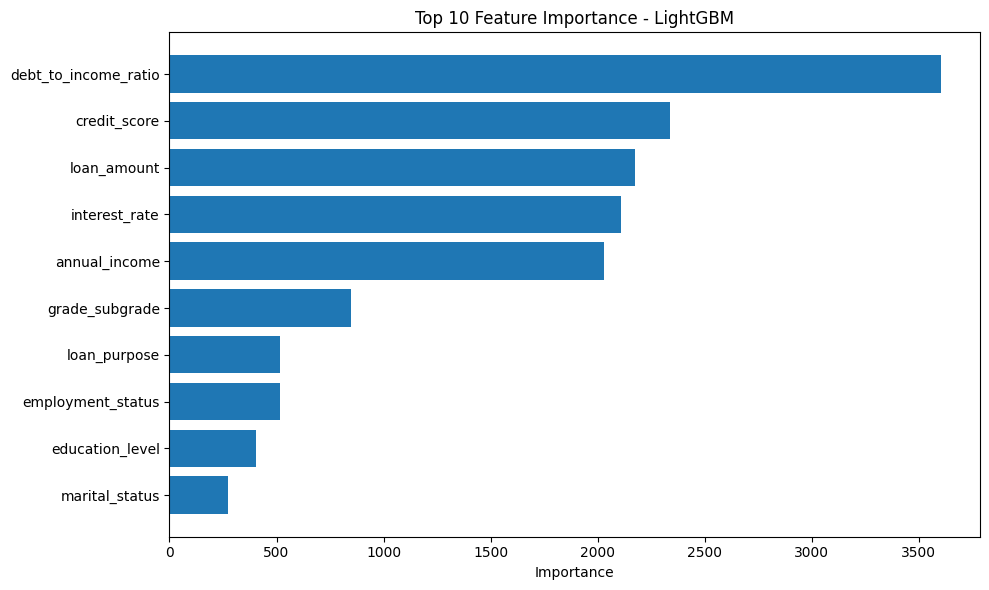

In [34]:
# ========================================
# 10. FEATURE IMPORTANCE (for tree models)
# ========================================

if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    print(f"\n📊 Feature Importance - {best_model_name}")
    
    if best_model_name == 'Random Forest':
        importances = best_model.feature_importances_
    elif best_model_name == 'XGBoost':
        importances = best_model.feature_importances_
    else:  # LightGBM
        importances = best_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    display(feature_importance_df)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'][:10], 
             feature_importance_df['importance'][:10])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [35]:
# ========================================
# 11. TEST PREDICTION
# ========================================

print("\n" + "="*60)
print("🧪 TESTING MODEL WITH SAMPLE DATA")
print("="*60)

# Load the actual feature names to ensure we match training data
print(f"\n📋 Model expects these features: {X_train.columns.tolist()}")
print(f"📊 Total features: {len(X_train.columns)}")

# Create test samples with ACTUAL feature structure
def create_test_sample(annual_income, debt_to_income_ratio, credit_score, 
                       loan_amount, interest_rate):
    """Create a test sample using median values from training data"""
    test_data = {}
    
    # Add the specific features
    test_data['annual_income'] = annual_income
    test_data['debt_to_income_ratio'] = debt_to_income_ratio
    test_data['credit_score'] = credit_score
    test_data['loan_amount'] = loan_amount
    test_data['interest_rate'] = interest_rate
    
    # Fill remaining features with median values from training data
    for col in X_train.columns:
        if col not in test_data:
            test_data[col] = X_train[col].median()
    
    return test_data

test_samples = [
    {
        'name': 'Good Applicant',
        'annual_income': 80000,
        'debt_to_income_ratio': 0.25,
        'credit_score': 750,
        'loan_amount': 15000,
        'interest_rate': 7.5,
        'expected': 'APPROVED ✅'
    },
    {
        'name': 'Bad Applicant',
        'annual_income': 25000,
        'debt_to_income_ratio': 0.85,
        'credit_score': 450,
        'loan_amount': 50000,
        'interest_rate': 18.0,
        'expected': 'REJECTED ❌'
    },
    {
        'name': 'Medium Applicant',
        'annual_income': 55000,
        'debt_to_income_ratio': 0.40,
        'credit_score': 650,
        'loan_amount': 25000,
        'interest_rate': 11.0,
        'expected': 'UNCERTAIN 🤔'
    }
]

for sample in test_samples:
    print(f"\n{'='*50}")
    print(f"👤 {sample['name']}")
    print(f"{'='*50}")
    print(f"  💰 Income: ${sample['annual_income']:,}")
    print(f"  💳 Loan Amount: ${sample['loan_amount']:,}")
    print(f"  📊 Credit Score: {sample['credit_score']}")
    print(f"  📈 Debt-to-Income: {sample['debt_to_income_ratio']:.2%}")
    print(f"  🎯 Interest Rate: {sample['interest_rate']}%")
    
    # Create properly structured test data
    test_data = create_test_sample(
        annual_income=sample['annual_income'],
        debt_to_income_ratio=sample['debt_to_income_ratio'],
        credit_score=sample['credit_score'],
        loan_amount=sample['loan_amount'],
        interest_rate=sample['interest_rate']
    )
    
    # Ensure correct feature order
    test_df = pd.DataFrame([test_data])[X_train.columns]
    test_scaled = scaler.transform(test_df)
    
    # Make prediction
    if best_model_name == 'Neural Network':
        prediction = best_model.predict(test_scaled, verbose=0)
        pred_class = (prediction > 0.5).astype(int)[0][0]
        probability = prediction[0][0]
    else:
        pred_class = best_model.predict(test_scaled)[0]
        probability = best_model.predict_proba(test_scaled)[0][1]
    
    result = "APPROVED ✅" if pred_class == 1 else "REJECTED ❌"
    print(f"\n  🔮 Prediction: {result}")
    print(f"  📊 Confidence: {probability:.2%}")
    print(f"  ✓ Expected: {sample['expected']}")
    
    if sample['expected'] != 'UNCERTAIN 🤔':
        if result == sample['expected']:
            print("  ✅ CORRECT PREDICTION!")
        else:
            print("  ⚠️ MISMATCH - Model may need retraining")

print("\n" + "="*60)
print("🎉 TRAINING & TESTING COMPLETE!")
print("="*60)


🧪 TESTING MODEL WITH SAMPLE DATA

📋 Model expects these features: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
📊 Total features: 11

👤 Good Applicant
  💰 Income: $80,000
  💳 Loan Amount: $15,000
  📊 Credit Score: 750
  📈 Debt-to-Income: 25.00%
  🎯 Interest Rate: 7.5%

  🔮 Prediction: APPROVED ✅
  📊 Confidence: 86.21%
  ✓ Expected: APPROVED ✅
  ✅ CORRECT PREDICTION!

👤 Bad Applicant
  💰 Income: $25,000
  💳 Loan Amount: $50,000
  📊 Credit Score: 450
  📈 Debt-to-Income: 85.00%
  🎯 Interest Rate: 18.0%

  🔮 Prediction: REJECTED ❌
  📊 Confidence: 23.31%
  ✓ Expected: REJECTED ❌
  ✅ CORRECT PREDICTION!

👤 Medium Applicant
  💰 Income: $55,000
  💳 Loan Amount: $25,000
  📊 Credit Score: 650
  📈 Debt-to-Income: 40.00%
  🎯 Interest Rate: 11.0%

  🔮 Prediction: APPROVED ✅
  📊 Confidence: 64.10%
  ✓ Expected: UNCERTAIN 🤔

🎉 TRAINING & TESTING COMPLETE!
